# DL Indaba Practical 4
# Gated Recurrent Models (GRUs and LSTMs)
*Developed by Stephan Gouws, Avishkar Bhoopchand & Ulrich Paquet.*

**Introduction**

So far we have looked at feedforward models which learn to map a single input **x** to a label (prediction) y. However, a lot of real-world data comes in the form of sequences, for example the words in natural languages, phonemes in speech, and so forth. In this practical we move from feed-forward models to ***sequence models*** which are designed to specifically model the **dependencies** between inputs in sequences of data that change over time. 

We will start with the basic/"vanilla" recurrent neural network (RNN) model. We will look at the intuition behind the model, and then approach it from a mathemetical as well as a programming point of view. Next we'll look at how to train RNNs, by discussing the Backpropagation-through-Time (BPTT) algorithm. Unfortunately, training RNNs still suffers from problems like vanishing and exploding grdients, so we will then look at how gated architectures overcome these issues. Finally we will implement an RNN and again apply this model to predict the labels of the handwritten MNIST images (yes! images can be thought of as **sequences of pixels**!). 

**Learning objectives**

* Understanding how to use deep learning to deal with sequential input data.
* Understanding how the vanilla RNN is the generalization of the DNN for sequential data.
* Understanding the BPPT algorithm and the difficulties involved with training RNNs.
* Understanding the GRU and LSTM architectures and how they help to solve some of these difficulties.

**What is expected of you:**
 * Complete the RNN forward pass code by filling in the sections marked "#IMPLEMENT-ME" until the fprop check passes on the dummy data.
 * Fill in the derivatives for `cell_fn_backward()` and get `rnn_gradient_check()` to pass.
 * Fill in the missing pieces of `RNNSequenceClassifer` and train a reccurrent classifier on MNIST data.
 * Experiment with different cells and observe the effect on trainin time/accuracy.
 

# Recurrent Neural Networks (RNNs)

**NOTE**: You can safely skip the first section below if you know RNNs. Skim the second and dip into the third, but be sure to resurface back at "Putting it all together"!

## The intuition

RNNs generalize feedforward networks (FFNs) to be able to work with sequential data. FFNs take an input (e.g. an image) and immediately produce an output (e.g. a digit class).    RNNs, on the other hand, consider the data sequentially and remembers what it has seen in the past in order to make new predictions about the future observations.

To understand this distinction, consider the example where we want to label words as the part-of-speech categories that they belong to: E.g. for the input sentence 'I want a duck' and 'He had to duck', we want our model to predict that duck is a noun in the first sentence and a verb in the second. To do this successfully, the model needs to be aware of the surrounding context.    However, if we feed a FFN model only one word at a time, how could it know the difference? If we want to feed it all the words at once, how do we deal with the fact that sentences are of different lengths? (We *could* try to find a trade-off by feeding it *windows of words*...)

RNNs solve this issue by processing the sentence word-by-word, and maintaining an internal state summarizing what it has seen so far. This applies not only to words, but also to phonemes in speech, or even, as we will see, pixels of an image.

## The RNN API

Feedforward neural networks operate on vectors of fixed size. As we have done before, we could think of the "[API](https://en.wikipedia.org/wiki/Application_programming_interface)" of feedforward models as follows:


In [21]:
class FeedForwardModel():
    
    # ...
    def act_fn(self, x):
        return np.tanh(x)
    
    def forward(self, x):
        '''One example of a FFN.'''
        # Compute activations on the hidden layer.
        hidden_layer = self.act_fn(np.dot(self.W_xh, x))
            
        # Compute the (linear) output layer activations.         
        output = np.dot(self.W_ho, hidden_layer)
        
        return output

Recurrent neural networks (RNNs) generalize this idea to operating on **sequences of vectors**. To process sequences, the model has an internal **state** which gets updated with each new observation. Computationally, one can think of this as recursively applying a function `recurrent_fn` to update the state of the model based on each new input in the sequence:

In [2]:
class RecurrentModel():
    
    # ...
    def act_fn(self, x):
        return np.tanh(x)

    def recurrent_fn(self, x, prev_state):
        '''Process the current input and the previous state and produce an output and a new state.'''
        # Compute the new state based on the previous state and current input.    
        new_state = self.act_fn(np.dot(self.W_hh, prev_state) + np.dot(self.W_xh, x))

        # Compute the output vector.
        y = np.dot(self.W_hy, new_state)

        return new_state, y


    def forward(self, data_sequence):

        state = self.init_state()
        all_states = [state]
        last_output = None

        for x in data_sequence:

            new_state, last_output = recurrent_fn(x, state)
            all_states.append(new_state)
            state = new_state

        return all_states, last_output

## Putting this together

Look at the definition of `hidden_layer` in `FeedForwardModel.forward()` and `new_state` in `RecurrentModel.forward()`. If you're more comfortable with math, compare the expression for computing the hidden layer of a feedforward neural network where ($\sigma$ is our non-linearity, tanh in the case shown above):

*    $h = \sigma(W_{xh}x)$

to the expression for computing the hidden layer at time step $t$ in an RNN:
    
* $h_t = \sigma(W_{hh}h_{t-1} + W_{xh}x_t)$

**NOTE**: The weight subscript $W_{xz}$ is used to indicate a mapping from layer $x$ to layer $z$. 
    
**QUESTIONS**:
 * How are they similar? 
 * How are they different?
 * Why is $W_{hh}$ called "recurrent" weights?
 
Spend a few min to think about and discuss this with your neighbour before you move on. 

## 'Unrolling' the network

Imagine we are trying to classify sequences `X` into labels `y` (for now, let's keep it abstract). After running the `forward()` function of our RNN defined above on `X`, we would have a list of internal states of the model at each sequence position, and the final state of the network. This process is called **unrolling in time**, because you can think of it as unrolling the *computation graph* defined by the RNN `forward` function, over the inputs at each position of the sequence.    RNNs are often used to model **time series data**, and therefore these positions are referred to as **time-steps**, hence, "unrolling over time".

![Unrolled RNN](images/rnn.jpg)

> **We can therefore think of an RNN as a composition of identical feedforward neural networks (with replicated/tied weights), one for each moment or step in time. **

These feedforward functions (i.e. our `recurrent_fn` above) are typically referred to as **cells**, and the only restriction on its API is that the cell function needs to be a differentiable function that can map an input and a state vector to an output and a new state vector. What we have shown above is called the **vanilla RNN**, but there are many more possibilities. In this practical, we will build up to a family of **gated-recurrent cells**. One of the most popular variants is called the **Long short-term memory** cell. But we're getting ahead of ourselves.

## Training RNNs: (Truncated) Back-prop through Time

RNNs model sequential data, and are designed to capture how ***outputs*** at the current time step are influenced by the ***inputs*** that came before them. This is referred to as **long-range dependencies**. At a high level, this allows the model to `remember` what it has seen so far in order to better contextualize what it is seeing at the moment (think about how knowing the context of the sentence or conversation can sometimes help one to better figure out the intended meaning of a misheard word or ambiguous statement). It is what makes these models so powerful, but it is also what makes them so hard to train!

### BPTT: A quick theoretical overview

The most well-known algorithm for training RNNs is called **back-propagation through time (BPTT)** (there are other algorithms). BPTT conceptually amounts to unrolling the computations of the RNN over time, computing the errors, and backpropagating the gradients through the unrolled graph structure.    Ideally we want to unroll the graph up to the maximum sequence length, however in practice, since sequence lengths vary and memory is limited, we only end up unrolling sequences up to some length $T$. This is called **truncated BPTT**, and is the most used variant of BPTT.

At a high level, there are two main issues when using (truncated) BPTT to train RNNs:

* Shared / tied recurrent weights ($W_{hh}$) mean that **the gradient on these weights at some time step $t$ depends on all time steps up to time-step $T$**, the maximum length of the unrolled graph. This also leads to the **vanishing/exploding gradients** problem.

* As alluded to above, **memory usage grows linearly with the total number of steps $T$ that we unroll for**, because we need to save/cache the activations at each time-step.    This matters computationally, since memory is a limited resource. It also matters statistically, because it puts a limit on the types of dependencies the model is exposed to, and hence that it could learn.

**NOTE**: Think about that last statement and make sure you understand those 2 points.

BPTT is very similar to the standard back-propagation algorithm. Key to understanding the BPTT algorithm is to realize that gradients on the non-recurrent weights (weights of a per time-step classifier that tries to predict the next word in a sentence for example) and recurrent weights (that transform $h_{t-1}$ into $h_t$) are computed differently:

* The gradients of **non-recurrent weights** ($W_{hy}$) depend only on the error at that time-step, $E_t$.
* The gradients of **recurrent weights** ($W_{hh}$) depend on all time-steps up to maximum length $T$.

The first point is fairly intuitive: predictions at time-step $t$ is related to the loss of that particular prediction. 

The second point will be explained in more detail in the lectures (see also [this great blog post](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/)), but briefly, this can be summarized in these equations:

1. The **current** state is a function of the **previous** state: $h_t = \sigma(W_{hh}h_{t-1} + W_{xh}x_t)$
2. The gradient of the loss $E_t$ at time $t$ on $W_{hh}$ is a function of the current hidden state and model predictions $\hat{y}_t$ at time t: 
$\frac{\partial E_t}{\partial W_{hh}} = \frac{\partial E_t}{\partial \hat{y}_t}\frac{\partial\hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial W_{hh}}$
3. Substituting (1) into (2) results in a **sum over all previous time-steps**:
$\frac{\partial E_t}{\partial W_{hh}} = \sum\limits_{k=0}^{t} \frac{\partial E_t}{\partial \hat{y}_t}\frac{\partial\hat{y}_t}{\partial h_t}\frac{\partial h_t}{\partial h_k}\frac{\partial h_k}{\partial W_{hh}}$

Because of this **repeated multiplicative interaction**, as the sequence length $t$ gets longer, the gradients themselves can get diminishingly small (**vanish**) or grow too large and result in numeric overflow (**explode**). This has been shown to be related to the norms of the recurrent weight matrices being less than or equal to 1. Intuitively, it works very similar to how multiplying a small number $v<1.0$ with itself repeatedly can quickly go to zero, or conversely, a large number $v>1.0$ could quickly go to infinity; only this is for matrices.


To implement this, we need three components:

* The code to fprop one time-step though the cell,
* the code to fprop through the unrolled RNN,
* the code to backprop one time-step through the cell, 

And then we'll put all this together within the BPTT algorithm. Let's start.

### Forward Propagation

Let's write the code to fprop one time-step though the cell. We'll need some helper functions:

In [3]:
import numpy as np

## HELPER DEFINITIONS 
## NOTE: WE KEEP THESE EXPLICIT BECAUSE WE WILL NEED THEIR DERIVATIVES BELOW.

def softmax(X):
    eX = np.exp((X.T - np.max(X, axis=1)).T)
    return (eX.T / eX.sum(axis=1)).T

def cross_entropy(y_pred, y_train):
    m = y_pred.shape[0]

    prob = softmax(y_pred)
    log_like = -np.log(prob[range(m), y_train])

    data_loss = np.sum(log_like) / m

    return data_loss

def fc_forward(X, W, b):
    '''A fully-connected feedforward layer.'''
    out = np.dot(X, W) + b
    cache = (W, X)
    return out, cache

def tanh_forward(X):
    out = np.tanh(X)
    cache = out
    return out, cache

Now we can implement the equation $h_t = \sigma(W_{hh}h_{t-1} + W_{xh}x_t)$ as follows:

In [4]:
## Define the RNN Cell. We use a vanilla RNN.
def cell_fn_forward(X, h, model, train=True):
    Wxh, Whh, Why = model['Wxh'], model['Whh'], model['Why']
    bh, by = model['bh'], model['by']

    hprev = h.copy()

    ## IMPLEMENT-ME: ... 
    h, h_cache = tanh_forward(np.dot(hprev, Whh) + np.dot(X, Wxh) + bh)
    y, y_cache = fc_forward(h, Why, by)

    cache = (X, Whh, h, hprev, y, h_cache, y_cache)

    if not train:
            # Compute per-time step outputs.
            # NOTE: Here we build a classifer, but it could be anything else.
            y = softmax(y)

    return y, h, cache


Put this together to do the RNN fprop over the entire sequence:

**QUESTION**: Notice how we save all activations in `caches`. Why do we need to do this?

In [5]:
def rnn_forward(X_train, y_train, model, initial_state, verbose=True):
    ys = []
    caches = []
    loss = 0.

    h = initial_state
    t = 0
    for x, y in zip(X_train, y_train):
        
        ## IMPLEMENT-ME: ... 
        y_pred, h, cache = cell_fn_forward(x, h, model, train=True)
        loss += cross_entropy(y_pred, y)
        ##
        
        ys.append(y_pred)
        caches.append(cache)
        
        if verbose:
            print "Time-step: ", t
            print "x_t = ", x
            print "cur_state = ", h
            print "predicted y = ", y_pred
            
        t += 1
    
    # We return final hidden state, predictions, caches and final total loss.
    return h, ys, caches, loss


Let's test this on some dummy data.

In [6]:
# Create a helper function that calculates the relative error between two arrays
def relative_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# We set the seed to make the results reproducible.
np.random.seed(1234)

def _initial_state(hidden_dim):
    return np.zeros((1, hidden_dim))

def _init_model(input_dim, hidden_dim, output_dim):
    D, H, C = input_dim, hidden_dim, output_dim # More compact.
    model_params = dict(
        Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
        Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
        Why=np.random.randn(H, D) / np.sqrt(C / 2.),
        bh=np.zeros((1, H)),
        by=np.zeros((1, D)))
    return model_params


# Initialize model.
input_dim=8
hidden_dim=4
output_dim=2    # num_classes
num_steps = 5

test_mdl = _init_model(input_dim, hidden_dim, output_dim)

# Create some dummy data (there's no batching, just num_steps input vectors)
X_test = np.split(np.random.randn(num_steps, input_dim), num_steps, axis=0)
y_test = np.random.randint(low=0, high=output_dim, size=num_steps).reshape(-1)
#y_onehot = np.eye(output_dim)[y_ids]

print "Created dummy input data X"
print "Created fake targets: ", y_test
#print "Created fake onehot targets: \n", y_onehot

print "\nRunning FPROP on dummy data: "

initial_state = _initial_state(hidden_dim)
last_state, ys, caches, loss = rnn_forward(X_test, y_test, test_mdl, initial_state, verbose=True)
    
print "Final hidden state: ", last_state

correct_final_state = np.array([[ 0.19868001,    0.98286478,    0.76491549, -0.91578737]])

# Compare your output to the "correct" ones 
# The difference should be around 2e-8 (or lower)
print "\n============================"
print 'Testing rnn_forward'
diff = relative_error(last_state, correct_final_state)
if diff <= 2e-8:
    print 'PASSED'
else:
    print 'The difference of %s is too high, try again' % diff
print "\n============================"

Created dummy input data X
Created fake targets:  [1 0 0 1 0]

Running FPROP on dummy data: 
Time-step:  0
x_t =  [[ 0.46439233 -3.56351666  1.32110562  0.15263055  0.16452954 -0.43009569
   0.76736874  0.98491984]]
cur_state =  [[ 0.96177185 -0.9949211  -0.32244779  0.73506912]]
predicted y =  [[ 0.55862327  1.40120743 -1.08963098 -1.08400572 -0.28057832 -1.1015924
  -0.11587845 -0.05159674]]
Time-step:  1
x_t =  [[ 0.27083585  1.39198619  0.07984231 -0.39996458 -1.02785056 -0.58471821
   0.81659393 -0.08194705]]
cur_state =  [[ 0.46602766  0.82754901  0.36055494 -0.95185866]]
predicted y =  [[ 0.34742921 -1.29286866  2.47391689 -1.71784312 -1.5992273   1.24601455
  -0.88538448 -0.11095221]]
Time-step:  2
x_t =  [[-0.34476601  0.52828815 -1.06898878 -0.51188131  0.29120536  0.5665337
   0.50359176  0.28529568]]
cur_state =  [[ 0.05420772  0.99026303  0.59787223 -0.29612811]]
predicted y =  [[ 0.8010615  -1.61368801  2.09415036  0.17450844 -0.9812788   0.68753718
  -0.38148559  0.05024

### Computing the derivative: Truncated BPTT 

Let's start with computing the per time-step derivative of `cell_fn_forward` wrt all model parameters. First, some helper derivative functions:

**NOTE**: Make sure you understand how these were derived.

In [7]:
## HELPER DERIVATIVE FUNCTIONS
def fc_backward(dout, cache):
    W, h = cache

    dW = np.dot(h.T, dout)
    db = np.sum(dout, axis=0)
    dX = np.dot(dout, W.T)

    return dX, dW, db

def tanh_backward(dout, cache):
    dX = (1 - cache**2) * dout
    return dX

def dcross_entropy(y_pred, y_train):
    m = y_pred.shape[0]
    
    grad_y = softmax(y_pred)
    grad_y[range(m), y_train] -= 1.
    grad_y /= m

    return grad_y

Let's put these together and write the code for $\frac{\partial E}{\partial \mathbf{\theta}}$ for all parameters $\mathbb{\theta} = \{W_{xh}, W_{hh}, W_{hy}, b_h, b_y\}$:

In [8]:
## PERFORM PER-TIMESTEP BACKWARD STEP
## IMPLEMENT-ME: Most of this (with hints).

def cell_fn_backward(y_pred, y_train, dh_next, cache):
    X, Whh, h, hprev, y, h_cache, y_cache = cache

    # Softmax gradient
    dy = dcross_entropy(y_pred, y_train)

    # Hidden to output gradient
    dh, dWhy, dby = fc_backward(dy, y_cache)
    dh += dh_next
    dby = dby.reshape((1, -1))

    # tanh
    dh = tanh_backward(dh, h_cache)

    # Hidden gradient
    dbh = dh
    dWhh = np.dot(hprev.T, dh)
    dWxh = np.dot(X.T, dh)
    dh_next = np.dot(dh, Whh.T)

    grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)

    return grad, dh_next

Now let's put this together inside the BPTT algorithm:

In [9]:
def bptt(model, X_train, y_train, initial_state):
    
    # Forward
    last_state, ys, caches, loss = rnn_forward(X_train, y_train, model, initial_state)

    loss /= y_train.shape[0]

    # Backward
    dh_next = np.zeros((1, last_state.shape[0]))
    grads = {k: np.zeros_like(v) for k, v in model.items()}

    for t in reversed(range(len(X_train))):
        grad, dh_next = cell_fn_backward(ys[t], y_train[t], dh_next, caches[t])

        for k in grads.keys():
                grads[k] += grad[k]

    for k, v in grads.items():
        grads[k] = np.clip(v, -5., 5.)

    return grads, loss, last_state


Finally, we can check our implementation using numerically-derived gradients:

In [10]:
def rnn_gradient_check(model, x, y, init_state, h=0.001, error_threshold=0.01):
    
    # Calculate the gradients using backpropagation. We want to checker if these are correct.
    bptt_gradients, _, _ = bptt(model, x, y, init_state)
    
    # List of all parameters we want to check.
    model_parameters = ['Wxh', 'Whh', 'Why', 'bh', 'by']
    
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the model, e.g. model.W
        parameter = model[pname]
        
        print "Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape))
        
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        
        while not it.finished:
            
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            
            ## IMPLEMENT-ME: ...

            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            # Compute the ENTIRE rnn_foward, evaluate cross entropy loss
            _, _, _, gradplus = rnn_forward(x, y, model, init_state, verbose=False)
            parameter[ix] = original_value - h
            _, _, _, gradminus = rnn_forward(x, y, model, init_state, verbose=False)
            estimated_gradient = (gradplus - gradminus)/(2*h)
            
            ##
            
            # Reset parameter to original value
            parameter[ix] = original_value
            
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pname][ix]
            
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient) / (np.abs(backprop_gradient) + np.abs(estimated_gradient))
            
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix)
                print "+h Loss: %f" % gradplus
                print "-h Loss: %f" % gradminus
                print "Estimated_gradient: %f" % estimated_gradient
                print "Backpropagation gradient: %f" % backprop_gradient
                print "Relative Error: %f" % relative_error
                return
            it.iternext()
        
        print "Gradient check for parameter %s: PASSED." % (pname)


Aaaaand let's test it!

In [11]:
rnn_gradient_check(test_mdl, X_test, y_test, initial_state)

Time-step:  0
x_t =  [[ 0.46439233 -3.56351666  1.32110562  0.15263055  0.16452954 -0.43009569
   0.76736874  0.98491984]]
cur_state =  [[ 0.96177185 -0.9949211  -0.32244779  0.73506912]]
predicted y =  [[ 0.55862327  1.40120743 -1.08963098 -1.08400572 -0.28057832 -1.1015924
  -0.11587845 -0.05159674]]
Time-step:  1
x_t =  [[ 0.27083585  1.39198619  0.07984231 -0.39996458 -1.02785056 -0.58471821
   0.81659393 -0.08194705]]
cur_state =  [[ 0.46602766  0.82754901  0.36055494 -0.95185866]]
predicted y =  [[ 0.34742921 -1.29286866  2.47391689 -1.71784312 -1.5992273   1.24601455
  -0.88538448 -0.11095221]]
Time-step:  2
x_t =  [[-0.34476601  0.52828815 -1.06898878 -0.51188131  0.29120536  0.5665337
   0.50359176  0.28529568]]
cur_state =  [[ 0.05420772  0.99026303  0.59787223 -0.29612811]]
predicted y =  [[ 0.8010615  -1.61368801  2.09415036  0.17450844 -0.9812788   0.68753718
  -0.38148559  0.05024376]]
Time-step:  3
x_t =  [[ 0.48428811  1.36348151 -0.78110528 -0.46801767  1.22457436 -1.2

# Gated Cells (GRUs and LSTMs)

Vanilla RNNs are very powerful sequence models. However, they are difficult to train, in large part due to the difficulties with getting gradients to propagate through all the time-steps without vanishing or exploding. If the gradient explodes then backpropagation will not work because we will get NaN values for the gradient contributions from earlier layers. The simplest trick to overcome this is called **gradient clipping** (see [Pascanu et al., 2013](http://www.jmlr.org/proceedings/papers/v28/pascanu13.pdf)). One basically rescales the gradients once their norms exceed a certain threshold. Dealing with vanishing gradients is trickier. Proper weight initialization helps to overcome this at the start of training (e.g [orthogonal initialization](https://www.tensorflow.org/api_docs/python/tf/orthogonal_initializer)), and there are regularization tricks for encouraging constant backwards error flow, which works for some tasks, but is not theoretically well-motivated.

Gated models (we will look at the GRU and LSTM) modify the architecture of the RNN cell to ensure constant gradient propagation. The problem with the vanilla RNN is that its entire state is multiplicatively updated (overwritten) at every time-step (notice the $W_{hh}h_{t-1}$ term): 

$h_t = \sigma(W_{hh}h_{t-1} ...)$

Gated cells (GRUs/LSTMs) have two main new ideas:

* Ensure **incremental state change** by updating state *additively*: $h_t = h_{t-1} + f(h_{t-1})$.
* Control the update process by selectively **modulating** how much to keep/forget of the old, how much to read, and how much to write into the new state.

These models modulate how much to throw away (forget) from the previous state when making a proposed new state, and then how much to read from the previous state and write to the output of the cell, by using **gates** (values between 0 and 1 which squash information flow to some extent; little neural networks, of course!). Gates are    vectors of *per-dimension interpolation scalars*: When you multiply some vector by a gate vector, you essentially control how much of that vector you "let through".    Below we show the generic equation for such a gate (they're all the same!):

$g_t = \sigma(W_g h_{t-1} + U_g x_t + b_g)$

where $\sigma(z) = 1 / (1+e^{-z})$ is the sigmoid function (i.e. $0 \leq \sigma(z) \leq 1.$). 

Think about this for a second:

* What are the inputs of this gate (model)?
* What are the parameters of this gate (model)?
* What does this remind you of? 

**NOTE**: Gates are just (vectors of) simple, logistic regression models which take inputs from the previous hidden layer $h_{t-1}$ and the current input layer $x_t$) and produce outputs between 0 and 1. 

Now let's use them to modulate the flow of information. We'll start with the GRU and build up to the LSTM.


## The Gated Recurrent Unit (GRU)

The GRU was introduced in 2014 by [Cho et al.](https://arxiv.org/pdf/1406.1078.pdf) -- almost 2 decades after the LSTM -- but we'll start here because the GRU is simpler than the LSTM and based on the same principle. It uses only two gates per cell, a reset gate $r_t$ and an update gate $z_t$ (not the same z from the previous practicals!). These are defined exactly like the generic gates above:

\begin{aligned}
 r_t &= \sigma(W_r h_{t-1} + U_r x_t + b_r) \\
 z_t &= \sigma(W_z h_{t-1} + U_z x_t + b_z) \\
\end{aligned}

First, it uses the **reset** gate to control how much of the previous state is used in computing the new proposed state:

$\tilde{h_t} = \phi(W(r_t \circ h_{t-1}) + Ux_t + b)$

(where $\circ$ is element-wise multiplication). Then it ties "reading" and "writing" of the LSTM (below) into an **update** gate (by bounding their sums to 1, i.e. the more you read the less you write) when the new state is calculated:

$h_t = z_t \circ h_{t-1} + (1 - z_t)\circ \tilde{h_t}$

Try to reconcile the equations with the following flow diagram of the same:

![GRU Cell](images/NH_GRUCell.png)

* What happens when the reset gate is high/low?
* What happens when the update gate is high/low?
* How do these two interact?
* Why would this architecture be more powerful than a vanilla RNN?

## The Long Short-Term Memory unit (LSTM)

The LSTM was introduced in 1997 by [Hochreiter and Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf). There are several different architectual variations 'out there', but they all operate by maintaining a separate **memory vector** $c_t$ and a **state vector** $h_t$ (i.e. the model computes a tuple of vectors per time-step, not just a single vector). We'll just focus on the "basic" LSTM version for now (we'll call this `BasicLSTM` in line with the name used in TensorFlow which we'll get to in the implementation section). It uses three gates, the **input**, **output** and **forget** gates, traditionally denoted by their first letters:

\begin{aligned}
 i_t &= \sigma(W_i h_{t-1} + U_i x_t + b_i) \\
 o_t &= \sigma(W_o h_{t-1} + U_o x_t + b_o) \\
 f_t &= \sigma(W_f h_{t-1} + U_f x_t + b_f) \\
\end{aligned}

Don't be intimidated by these equations. We've seen them all above already in their generic form. They're all just doing the same thing (computationally, not functionally). Convince yourself of this, by answering the following:

* What is the **same** between these equations?
* What is **different** between them?

Now let's step through the rest of the `BasicLSTM` Cell:

1. First, the `BasicLSTM` Cell uses no gating to create the proposed new hidden state (original notation uses g, but I use tilde h):

            $\tilde{h}_t = \phi(W h_{t-1}) + Ux_t + b)$

2. Then it updates its internal memory to be a combination of the previous memory $c_{t-1}$ (multiplied/modulated by the forget gates $f_t$) and the new proposed state $\tilde{h}_t$ (modulated by the input gates $i_t$):

            $c_t = f_t \circ c_{t-1} + i_t \circ \tilde{h}_t$

            **Intuitively**: the model could choose to ignore old memory completely (if $f_t$ is all 1s), or ignore the newly proposed state completely ($i_t$ all 0s), but more likely it would learn to do something in-between. **QUESTION**: Think about how and why this behaviour would be encouraged (learned) during training? 

3. Finally, the *state* that is actually output by the cell is a gated version of the memory vector, squashed by a tanh (because not everything in the memory cell might be immediately useful to the surrounding network):

            $ h_t = o_t \circ \phi(c_t) $

*Phewwww*. We know.. there is a lot going on here! The following flow-diagram might help a bit to make this more clear:

![LSTM Cell](images/NH_BasicLSTMCell.png)

Look at the equations and at the flow-diagram, and then try to answer the following questions:

* How is the LSTM similar to the GRU?
* How is it different?
* What is the function of the memory vector (think about edge cases, e.g. where the forget gate is set to all 1s)?
* Is the LSTM theoretically more powerful than the GRU? If so, why?
* What is the computational drawback to using LSTMs (think about the number of gates; these must be parameterized..)?

# Implementing Recurrent Models in TensorFlow

In TensorFlow, we implement recurrent models using two building blocks:

 1. A (graph) definition for the cell (you can use [those provided](https://www.tensorflow.org/versions/r1.0/api_guides/python/contrib.rnn#Base_interface_for_all_RNN_Cells), or you can write your own); and
 2. A method to unroll the graph over the sequence (dynamic vs unrolled).
 
First, TensorFlow provides implementations for many of the standard RNN cells. Poke around in the docs.

Second, TensorFlow provides two different ways to implement the recurrence operations: **dynamic or static**. Basically, static unrolling prebuilds the entire unrolled RNN over the maximum number of time-steps. Dynamic unrolling dynamically creates the graph at each time-step, and saves the activations during the forward phase for the backward phase.

**QUESTION**: Why do activations need to be saved during the forward phase? (HINT: Look at our use of `cache` in the Numpy code above).

We will use dynamic unrolling: it uses less memory, and (counterintuitively), oftentimes it turns out to be faster.

In [12]:
import tensorflow as tf

import numpy as np
import functools

from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# An RNN Image Labeler

Let's reuse the BaseSoftmaxClassifier from the previous practicals:

In [13]:
class BaseSoftmaxClassifier(object):
    def __init__(self, input_size, output_size, l2_lambda):        
        # Define the input placeholders. The "None" dimension means that the 
        # placeholder can take any number of images as the batch size. 
        self.x = tf.placeholder(tf.float32, [None, input_size], name='x')
        self.y = tf.placeholder(tf.float32, [None, output_size], name='y')    
        self.input_size = input_size
        self.output_size = output_size
        self.l2_lambda = l2_lambda

        self._all_weights = [] # Used to compute L2 regularization in compute_loss().
        
        # You should override these in your build_model() function.
        self.logits = None
        self.predictions = None
        self.loss = None
        
        self.build_model()
        
    def get_logits(self):
        return self.logits
    
    def build_model(self):
        # OVERRIDE THIS FOR YOUR PARTICULAR MODEL.
        raise NotImplementedError("Subclasses should implement this function!")
        
    def compute_loss(self):
        """All models share the same softmax cross-entropy loss."""
        assert self.logits is not None    # Ensure that logits has been created! 
        data_loss = tf.reduce_mean(
                tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.y))
        reg_loss = 0.
        for w in self._all_weights:
            reg_loss += tf.nn.l2_loss(w)
            
        return data_loss + self.l2_lambda * reg_loss
    
    def accuracy(self):
        # Calculate accuracy.
        assert self.predictions is not None    # Ensure that pred has been created!
        correct_prediction = tf.equal(tf.argmax(self.predictions, 1), tf.argmax(self.y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        return accuracy

We override `build_model()` to build the graph for the RNN classifier.

In [14]:
class RecurrentClassifier(BaseSoftmaxClassifier):
    def __init__(self, model_params):
            
        self.config = model_params

        super(RecurrentClassifier, self).__init__(model_params['input_size'],
                                                  model_params['output_size'],
                                                  model_params['l2_lambda'])
             

    def build_model(self):
                
        assert self.config['num_steps'] * self.config['pixels_per_step'] == self.config['input_size']
        # We break up the input images into num_steps groups of pixels_per_step
        # pixels each.        
        rnn_input = tf.reshape(self.x, [-1, 
                                        self.config['num_steps'], 
                                        self.config['pixels_per_step']])

        ## IMPLEMENT-ME: ... 

        # Define the main RNN 'cell', that will be applied to each timestep.
        cell = self.config['cell_fn'](self.config['memory_units'])
        # NOTE: This is how we apply Dropout to RNNs.
        cell = tf.contrib.rnn.DropoutWrapper(
                cell, 
                output_keep_prob = self.config['dropout_keep_prob'])
        cell = tf.contrib.rnn.MultiRNNCell(cells=[cell] * self.config['num_layers'],
                                           state_is_tuple=True)
        ##########
                
        outputs, state = tf.nn.dynamic_rnn(cell, 
                                           rnn_input, 
                                           dtype=tf.float32)
                
        # Transpose the cell to get the output from the last timestep for each batch.
        output = tf.transpose(outputs, [1, 0, 2])
        last_hiddens = tf.gather(output, int(output.get_shape()[0]) - 1)
                
        # Define weights and biases for output prediction.
        out_weights = tf.Variable(tf.random_normal([self.config['memory_units'],
                                                    self.config['output_size']]))
        self._all_weights.append(out_weights)
                
        out_biases = tf.Variable(tf.random_normal([self.config['output_size']]))
                
        self.logits = tf.matmul(last_hiddens, out_weights) + out_biases
                
        self.predictions = tf.nn.softmax(self.logits)
        self.loss = self.compute_loss()
                
        
    def get_logits(self):
        return self.logits

In [15]:
class MNISTFraction(object):
    """A helper class to extract only a fixed fraction of MNIST data."""
    def __init__(self, mnist, fraction):
        self.mnist = mnist
        self.num_images = int(mnist.num_examples * fraction)
        self.image_data, self.label_data = mnist.images[:self.num_images], mnist.labels[:self.num_images]
        self.start = 0
        
    def next_batch(self, batch_size):
        start = self.start
        end = min(start + batch_size, self.num_images)
        self.start = 0 if end == self.num_images else end
        return self.image_data[start:end], self.label_data[start:end]

In [16]:
def train_tf_model(tf_model,                                     
                   session,    # The active session.
                   num_epochs,    # Max epochs/iterations to train for.
                   batch_size=50,    # Number of examples per batch.
                   keep_prob=1.0,    # (1. - dropout) probability, none by default.
                   train_only_on_fraction=1.,    # Fraction of training data to use.
                   optimizer_fn=None,    # TODO(sgouws): more correct to call this optimizer_obj
                   report_every=1, # Report training results every nr of epochs.
                   eval_every=1,    # Evaluate on validation data every nr of epochs.
                   stop_early=True,    # Use early stopping or not.
                   verbose=True): 

    # Get the (symbolic) model input, output, loss and accuracy.
    x, y = tf_model.x, tf_model.y
    loss = tf_model.loss
    accuracy = tf_model.accuracy()

    # Compute the gradient of the loss with respect to the model parameters 
    # and create an op that will perform one parameter update using the specific
    # optimizer's update rule in the direction of the gradients.
    if optimizer_fn is None:
        optimizer_fn = tf.train.AdamOptimizer()
    optimizer_step = optimizer_fn.minimize(loss)

    # Get the op which, when executed, will initialize the variables.
    init = tf.global_variables_initializer()
    # Actually initialize the variables (run the op).
    session.run(init)

    # Save the training loss and accuracies on training and validation data.
    train_costs = []
    train_accs = []
    val_costs = []
    val_accs = []

    if train_only_on_fraction < 1:
        mnist_train_data = MNISTFraction(mnist.train, train_only_on_fraction)
    else:
        mnist_train_data = mnist.train
    
    prev_c_eval = 1000000
    
    # Main training cycle.
    for epoch in range(num_epochs):

        avg_cost = 0.
        avg_acc = 0.
        total_batch = int(train_only_on_fraction * mnist.train.num_examples / batch_size)

        ## IMPLEMENT-ME: ...
        # Loop over all batches.
        for i in range(total_batch):
            batch_x, batch_y = mnist_train_data.next_batch(batch_size)
                            
            # Run optimization op (backprop) and cost op (to get loss value),
            # and compute the accuracy of the model.
            feed_dict = {x: batch_x, y: batch_y}
            if keep_prob < 1.:
                feed_dict["keep_prob:0"] = keep_prob
                
            _, c, a = session.run(
                    [optimizer_step, loss, accuracy], feed_dict=feed_dict)
                        
            # Compute average loss/accuracy
            avg_cost += c / total_batch
            avg_acc += a / total_batch            
        
        train_costs.append((epoch, avg_cost))
        train_accs.append((epoch, avg_acc))

        # Display logs per epoch step
        if epoch % report_every == 0 and verbose:
            print "Epoch:", '%04d' % (epoch+1), "Training cost =", \
                        "{:.9f}".format(avg_cost)
                
        if epoch % eval_every == 0:
            val_x, val_y = mnist.validation.images, mnist.validation.labels            
            
            feed_dict = {x : val_x, y : val_y}
            if keep_prob < 1.:
                feed_dict['keep_prob:0'] = 1.0
                
            c_eval, a_eval = session.run([loss, accuracy], feed_dict=feed_dict)
            
            if verbose:
                print "Epoch:", '%04d' % (epoch+1), "Validation acc=", \
                            "{:.9f}".format(a_eval)
                
            if c_eval >= prev_c_eval and stop_early:
                print "Validation loss stopped improving, stopping training early after %d epochs!" % (epoch + 1)
                break
                
            prev_c_eval = c_eval
                
            val_costs.append((epoch, c_eval))
            val_accs.append((epoch, a_eval))
            
    
    print "Optimization Finished!"
    return train_costs, train_accs, val_costs, val_accs


In [17]:
# Helper functions to plot training progress.

from matplotlib import pyplot as plt

def my_plot(list_of_tuples):
    """Take a list of (epoch, value) and split these into lists of 
    epoch-only and value-only. Pass these to plot to make sure we
    line up the values at the correct time-steps.
    """
    plt.plot(*zip(*list_of_tuples))

def plot_multi(values_lst, labels_lst, y_label, x_label='epoch'):
    # Plot multiple curves.
    assert len(values_lst) == len(labels_lst)
    plt.subplot(2, 1, 2)
    
    for v in values_lst:
        my_plot(v)
    plt.legend(labels_lst, loc='upper left')
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()    


/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 0001 Training cost = 1.700093461
Epoch: 0001 Validation acc= 0.907999992
Epoch: 0002 Training cost = 1.251337544
Epoch: 0002 Validation acc= 0.940800011
Epoch: 0003 Training cost = 1.019042170
Epoch: 0003 Validation acc= 0.942399979
Epoch: 0004 Training cost = 0.843147734
Epoch: 0004 Validation acc= 0.964600027
Epoch: 0005 Training cost = 0.691543338
Epoch: 0005 Validation acc= 0.965200007
Epoch: 0006 Training cost = 0.573340431
Epoch: 0006 Validation acc= 0.966400027
Epoch: 0007 Training cost = 0.473180537
Epoch: 0007 Validation acc= 0.961000025
Epoch: 0008 Training cost = 0.399561708
Epoch: 0008 Validation acc= 0.967800021
Epoch: 0009 Training cost = 0.346471880
Epoch: 0009 Validation acc= 0.977400005
Epoch: 0010 Training cost = 0.288886438
Epoch: 0010 Validation acc= 0.968400002
Epoch: 0011 Training cost = 0.251895951
Epoch: 0011 Validation acc= 0.974399984
Epoch: 0012 Training cost = 0.206501909
Epoch: 0012 Validation acc= 0.971599996
Epoch: 0013 Training cost = 0.183243006


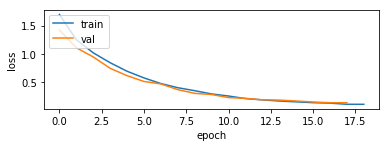

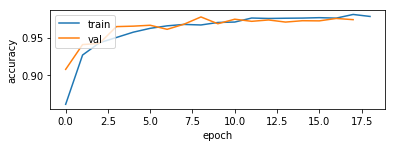

CPU times: user 30min 21s, sys: 41 s, total: 31min 2s
Wall time: 10min 10s


In [18]:
%%time

def build_train_eval_and_plot(model_params, train_params, verbose=True):
    
    tf.reset_default_graph()
    m = RecurrentClassifier(model_params)

    with tf.Session() as sess:
        # Train model on the MNIST dataset.
     
        train_losses, train_accs, val_losses, val_accs = train_tf_model(
                m, 
                sess,
                verbose=verbose,
                **train_params) 
        
        # Now evaluate it on the test set:
    
        accuracy_op = m.accuracy()    # Get the symbolic accuracy operation
        # Calculate the accuracy using the test images and labels.
        accuracy = accuracy_op.eval({m.x: mnist.test.images, 
                                                                 m.y: mnist.test.labels})    
        
        if verbose: 
            print "Accuracy on test set:", accuracy
            # Plot losses and accuracies.
            plot_multi([train_losses, val_losses], ['train', 'val'], 'loss', 'epoch')
            plot_multi([train_accs, val_accs], ['train', 'val'], 'accuracy', 'epoch')
            
        
        ret = {'train_losses': train_losses, 'train_accs' : train_accs,
                     'val_losses' : val_losses, 'val_accs' : val_accs,
                     'test_acc' : accuracy}
        
        return m, ret

#################################CODE TEMPLATE##################################
# Specify the model hyperparameters:
model_params = {
        'input_size' : 784,
        'output_size' : 10,
        'batch_size'    : 100,
        'num_steps' : 28,                    
        'pixels_per_step' : 28,    # NOTE: num_steps * pixels_per_step must = input_size
        'cell_fn' : tf.contrib.rnn.BasicRNNCell,
        'memory_units' : 256,
        'num_layers' : 1,
        'l2_lambda' : 1e-3,
        'dropout_keep_prob': 1.
}


# Specify the training hyperparameters:
training_params = {
        'num_epochs' : 100,     # Max epochs/iterations to train for.
        'batch_size' : 100,    # Number of examples per batch, 100 default.
        #'keep_prob' : 1.0,    # (1. - dropout) probability, none by default.
        'train_only_on_fraction' : 1.,    # Fraction of training data to use, 1. for everything.
        'optimizer_fn' : None,    # Optimizer, None for Adam.
        'report_every' : 1, # Report training results every nr of epochs.
        'eval_every' : 1,     # Evaluate on validation data every nr of epochs.
     'stop_early' : True,    # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)

###############################END CODE TEMPLATE################################

## Exercise:    Try out different cells!

Replace the BasicRNN cell with the BasicLSTMCell. What is the effect on accuracy?

In [19]:
# Your code here...

## Known good settings

We got **98.8%** with this model and hyperparams:

Epoch: 0001 Training cost = 0.942025948
Epoch: 0001 Validation acc= 0.959200025
Epoch: 0002 Training cost = 0.493692306
Epoch: 0002 Validation acc= 0.974200010
Epoch: 0003 Training cost = 0.326208413
Epoch: 0003 Validation acc= 0.979399979
Epoch: 0004 Training cost = 0.222589417
Epoch: 0004 Validation acc= 0.979399979
Epoch: 0005 Training cost = 0.157068045
Epoch: 0005 Validation acc= 0.984399974
Epoch: 0006 Training cost = 0.112189237
Epoch: 0006 Validation acc= 0.984200001
Epoch: 0007 Training cost = 0.087417065
Epoch: 0007 Validation acc= 0.985199988
Epoch: 0008 Training cost = 0.068945501
Epoch: 0008 Validation acc= 0.986999989
Epoch: 0009 Training cost = 0.059829582
Epoch: 0009 Validation acc= 0.986199975
Epoch: 0010 Training cost = 0.051920293
Epoch: 0010 Validation acc= 0.987800002
Epoch: 0011 Training cost = 0.046502204
Epoch: 0011 Validation acc= 0.985800028
Validation loss stopped improving, stopping training early after 11 epochs!
Optimization Finished!
Accuracy on test set:

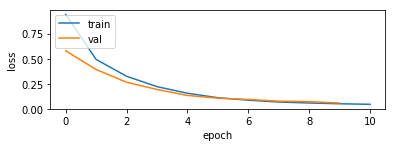

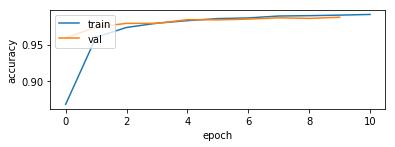

In [20]:
# Specify the model hyperparameters:
model_params = {
        'input_size' : 784,
        'output_size' : 10,
        'batch_size'    : 100,
        'num_steps' : 28,                    
        'pixels_per_step' : 28,    # NOTE: num_steps * pixels_per_step must = input_size
        'cell_fn' : tf.contrib.rnn.BasicLSTMCell,
        'memory_units' : 128,
        'num_layers' : 1,
        'l2_lambda' : 1e-3,
        'dropout_keep_prob': 1.
}


# Specify the training hyperparameters:
training_params = {
        'num_epochs' : 100,     # Max epochs/iterations to train for.
        'batch_size' : 100,    # Number of examples per batch, 100 default.
        #'keep_prob' : 1.0,    # (1. - dropout) probability, none by default.
        'train_only_on_fraction' : 1.,    # Fraction of training data to use, 1. for everything.
        'optimizer_fn' : None,    # Optimizer, None for Adam.
        'report_every' : 1, # Report training results every nr of epochs.
        'eval_every' : 1,     # Evaluate on validation data every nr of epochs.
     'stop_early' : True,    # Use early stopping or not.
}

# Build, train, evaluate and plot the results!
trained_model, training_results = build_train_eval_and_plot(
        model_params, 
        training_params, 
        verbose=True    # Modify as desired.
)


# NB: Before you go (5min)

Pair up with someone else and go through the questions in "Learning Objectives" at the top. Take turns explaining each of these to each other, and be sure to ask the tutors if you're both unsure!

# Resources

* https://r2rt.com/written-memories-understanding-deriving-and-extending-the-lstm.html
* HipsterNet Code: https://github.com/wiseodd/hipsternet/blob/master/hipsternet/neuralnet.py
* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/
* http://peterroelants.github.io/posts/rnn_implementation_part01/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/


# Feedback

Please send any bugs and comments to dli-practicals@googlegroups.com.